In [245]:
# HP-TES sizing
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

## Define Peak Price and Peak load overlap (discharge time) and charge time

Lets say 12 - 6 pm is discharge 8pm to 10 am is charge

## Find HP Sizing Trapezoid

Points start in bottom right, and the perimeter of the sizing trapezoid is drawn clockwise from point 1 to point 2 to point 3, etc.

Notes:
USE CELL B AS REFERENCE or one without PCM
Could aggregate for multiple dates
Aggregation Methods:
 - Average multiple dates together, chosen visually
 - Select several of the highest max load days, average the trapezoids
 - Select several highest load days, average days then generate trapezoid
 - Select days with highest load DURING peak period
 - Select days with highest average of load and energy (during peak period or full day)


In [223]:
# times must be 2 digit strings, 24 hour format
charge_st = '20'
charge_et = '10'
charge_duration = 10
discharge_st = '12'
discharge_et = '20'

In [224]:
# formatting data
df = pd.read_csv('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', index_col= 'Time', parse_dates= True)
df.head()

,1A-Th-Chilled Water
Time,
2021-08-09 13:28:00,2.20 kW
2021-08-09 13:29:00,2.48 kW
2021-08-09 13:33:00,1.75 kW
2021-08-09 13:34:00,1.59 kW
2021-08-09 13:35:00,1.51 kW


In [225]:
def get_kW(str_val):
    str_splt = str_val.split(' ')
    if str_splt[1] == 'kW':
        return float(str_splt[0])
    elif str_splt[1] == 'W':
        return float(str_splt[0])/1000
    elif str_splt[1] == 'mW':
        return float(str_splt[0])/1000000
    elif str_splt[1] == 'µW':
        return float(str_splt[0])/1000000000  
    else:
        print(str_val)
        #return 0 
        raise(Exception('not kW or W or mW or µW'))


In [226]:
df['value'] = df['1A-Th-Chilled Water'].apply(get_kW)
df = df.drop(columns = '1A-Th-Chilled Water')
df.head()

,value
Time,
2021-08-09 13:28:00,2.20
2021-08-09 13:29:00,2.48
2021-08-09 13:33:00,1.75
2021-08-09 13:34:00,1.59
2021-08-09 13:35:00,1.51


In [230]:
7 - 23 + 24

8

datetime.date(2021, 10, 6)

In [254]:
max_day.replace(hour = 6)

TypeError: 'hour' is an invalid keyword argument for replace()

In [250]:
datetime.strftime(max_day, '%Y-%m-%d')

'2021-10-06'

In [148]:
peak_ser = df.loc[f'2021-10-09 {discharge_st}:00:00': f'2021-10-10 {discharge_et}:00:00', 'value']
peak_energy = peak_ser.sum()/60
#charge_energy = df.loc[f'2021-10-09 {charge_st}:00:00': f'2021-10-10 {charge_et}:00:00', 'value'].sum()/60

In [149]:
# Point 1 (B) - Size HP for Peak Load

''' 
HP Capacity (kW) is x axis, TES size (kWh) is y axis
Find peak load (kW) and make that the Heat Pump capacity without any TES
This is refered to as Point B
'''
# hp_size_max = df.max().value # not using peak day
hp_size_max = peak_ser.max() # using value in peak period
point_1 = (hp_size_max, 0)
print(point_1)

(6.24, 0)


In [150]:
# Point 2 (between A and B) - Size TES to reduce HP capacity

'''
Potentially unnecessary point

Possible intermediate size: 
    Full cooling load for single Peak price hour within discharge window
    Half the size 
'''
hp_size = 0.5 * hp_size_max

TES_size = peak_ser.loc[peak_ser - hp_size > 0].sum()/60 # load during peak period above what HP can provide

point_2 = (hp_size, TES_size)
print(point_2)



(3.12, 38.563833333333335)


In [151]:
# Point 3 (A) - Minimize HP capacity
'''
Energy needed during peak - HP Capacity * discharge time - TES size = 0 (all energy at peak satisfied) 
hp_size = peak_energy / (charge_time + discharge_time)

This is essentially the bottom line of the trapezoid
'''
size_reduction = -0.005
hp_size = hp_size_max 
for i in range(0,10000):
    # TES_size_prev = TES_size
    # hp_size_prev = hp_size
    hp_size = hp_size + size_reduction * i
    TES_size = peak_ser.loc[peak_ser - hp_size > 0].sum()/60

    if TES_size > (hp_size * charge_duration):
        break

    #size_reduction = (TES_size_prev - TES_size)/(hp_size_prev - hp_size)
point_3 = (hp_size,TES_size)


In [152]:
point_3

(3.4350000000000014, 35.81733333333333)

In [248]:
datetime.strptime('2021-10-10', '%Y-%m-%d')

datetime.datetime(2021, 10, 10, 0, 0)

In [153]:
# Point 4 C - Find TES size to supply all energy during discharge window
''' 
peak energy = HP capacity * charge time
''' 
TES_size = peak_energy
hp_size = TES_size/charge_duration 
point_4 = (hp_size, TES_size)
print(point_4)


(5.664511708333334, 56.64511708333334)


In [154]:
# Point 5 (D) - Maximum TES Size and maximum HP size

##  Class/Functions for plotting

In [299]:
class HP_sizer():

    def __init__(self, file, charge_p, discharge_p, day = None):
        df = pd.read_csv(file, index_col= 'Time', parse_dates= True)
        df['value'] = df['1A-Th-Chilled Water'].apply(self.parse_val_string)
        self.df = df.drop(columns = '1A-Th-Chilled Water')

        if day: 
            self.date = datetime.strptime(day, '%Y-%m-%d')
        else:
            self.date = self.select_day(self.df)
        charge_st = (self.date - timedelta(days = 1)).replace(hour = charge_p[0])
        charge_et = (self.date).replace(hour = charge_p[1])
        print(f'charge series from {charge_st} to {charge_et}')

        peak_st = (self.date).replace(hour = discharge_p[0])
        peak_et = (self.date).replace(hour = discharge_p[1])
        print(f'discharge series from {peak_st} to {peak_et}')

        self.peak_ser = df.loc[peak_st: peak_et, 'value']
        self.peak_energy = self.peak_ser.sum()/60

        self.charge_ser = df.loc[charge_st: charge_et, 'value']

        self.hp_size_max = self.peak_ser.max() # probably shouldn't get this from peak series, should be from whole day

        self.charge_p = charge_p
        self.discharge_p = discharge_p

        self.point_1 = (self.hp_size_max, 0)

    def select_day(self, df):
        # Can try different aggregation methods here
        # Day with highest peak load
        # make select days? 
        max_day = df.loc[df['value'] == df['value'].max()].index[0]
        return max_day.replace(hour = 0, minute=0, second=0)
        
    def _tes_size(self, hp_size):
        # should add something to make sure load is ALWAYS satisfied
        # return hp_size * (self.charge_p[1] - self.charge_p[0] + 24)# engineering estimation, HP size * duration of charge
        return (hp_size - self.charge_ser).sum()/60 # ALL unused HP capacity goes to TES

    def plot(self):
        x, y = self._bottom()
        x2,y2= self._top()
        x3,y3 = self._right()
        plt.plot(x,y)
        plt.plot(x2,y2)
        plt.plot(x3,y3)
        plt.xlabel('HP Capacity (kW)')
        plt.ylabel('TES Size (kWh)')
        plt.show()

    def _bottom(self):

        hp_size = self.hp_size_max
        size_reduction = -0.005 

        x = []
        y = []
        for i in range(0,10000):
        
            hp_size = hp_size + size_reduction * i
            TES_size = self.peak_ser.loc[self.peak_ser - hp_size > 0].sum()/60

            x.append(hp_size)
            y.append(TES_size)

            if TES_size > self._tes_size(hp_size):
                break
            
        self.point_2 = (hp_size,TES_size)

        return x, y

    def _top(self):
        # MUST run bottom before top
        x = []
        y = []
        hp_size = self.hp_size_max
        size_reduction = -0.005 

        for i in range(0,10000):
            hp_size = hp_size + size_reduction * i

            # may want to draw top, then another line for the maximum based on peak energy provided by TES
            TES_size = self._tes_size(hp_size) # should subtract load in this period to make better estimate

            if TES_size > self.peak_energy:
                y.append(self.peak_energy)
            else:
                y.append(TES_size)
            x.append(hp_size)

            if hp_size <= self.point_2[0]: # This is cheating a bit
                break
            
        return x, y

    def _right(self):
        # This whole function is cheaty
        x = []
        y = []

        x.append(self.point_1[0])
        x.append(self.point_1[0])

        y.append(self.peak_energy)
        y.append(0)

        return x,y 
            

    def parse_val_string(self, str_val):
        str_splt = str_val.split(' ')
        if str_splt[1] == 'kW':
            return float(str_splt[0])
        elif str_splt[1] == 'W':
            return float(str_splt[0])/1000
        elif str_splt[1] == 'mW':
            return float(str_splt[0])/1000000
        elif str_splt[1] == 'µW':
            return float(str_splt[0])/1000000000  
        else:
            print(str_val)
            #return 0 
            raise(Exception('not kW or W or mW or µW'))

In [300]:
hps = HP_sizer('Cell 1A_1B Chilled Water Load -data-2022-09-30 00_41_29.csv', charge_p=(20,10), discharge_p=(12,20), day = '2021-10-10') # specify date range?

charge series from 2021-10-09 20:00:00 to 2021-10-10 10:00:00
discharge series from 2021-10-10 12:00:00 to 2021-10-10 20:00:00


In [301]:
hps.peak_ser.sum()/60

22.224600000000002

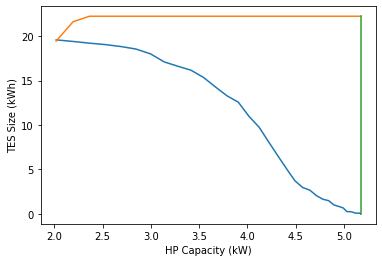

In [302]:
hps.plot()

In [252]:
day = '2021-10-10'
date = datetime.strptime(day, '%Y-%m-%d')
datetime.strftime(date - timedelta(days = 1), '%Y-%m-%d')

'2021-10-09'